In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import altair as alt
from PIL import Image
import geojson

from gcnSurrogate.models.feastnetSurrogateModel import FeaStNet
from gcnSurrogate.readers.loadConmechGraphs import loadConmechGraphs
from gcnSurrogate.visualization.altTrussViz import plotTruss, interactiveErrorPlot
from gcnSurrogate.util.gcnSurrogateUtil import *

In [2]:
def saveAsImage(fig, imgFile, widthInches=3.25, dpi=500, tempFile='figures/temp.png'):
    fig.save(tempFile, scale_factor=1.0)
    img = Image.open(tempFile)
    fig.save(imgFile, scale_factor=widthInches*dpi/img.size[0])
    img2 = Image.open(imgFile)
    if os.path.exists(tempFile): os.remove(tempFile)
    print(f'image size: {img2.size}')
    return img2

# Design space and loading conditions

loading from data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_1_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_2_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_3_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_4_7_N_5/
image size: (1625, 1342)


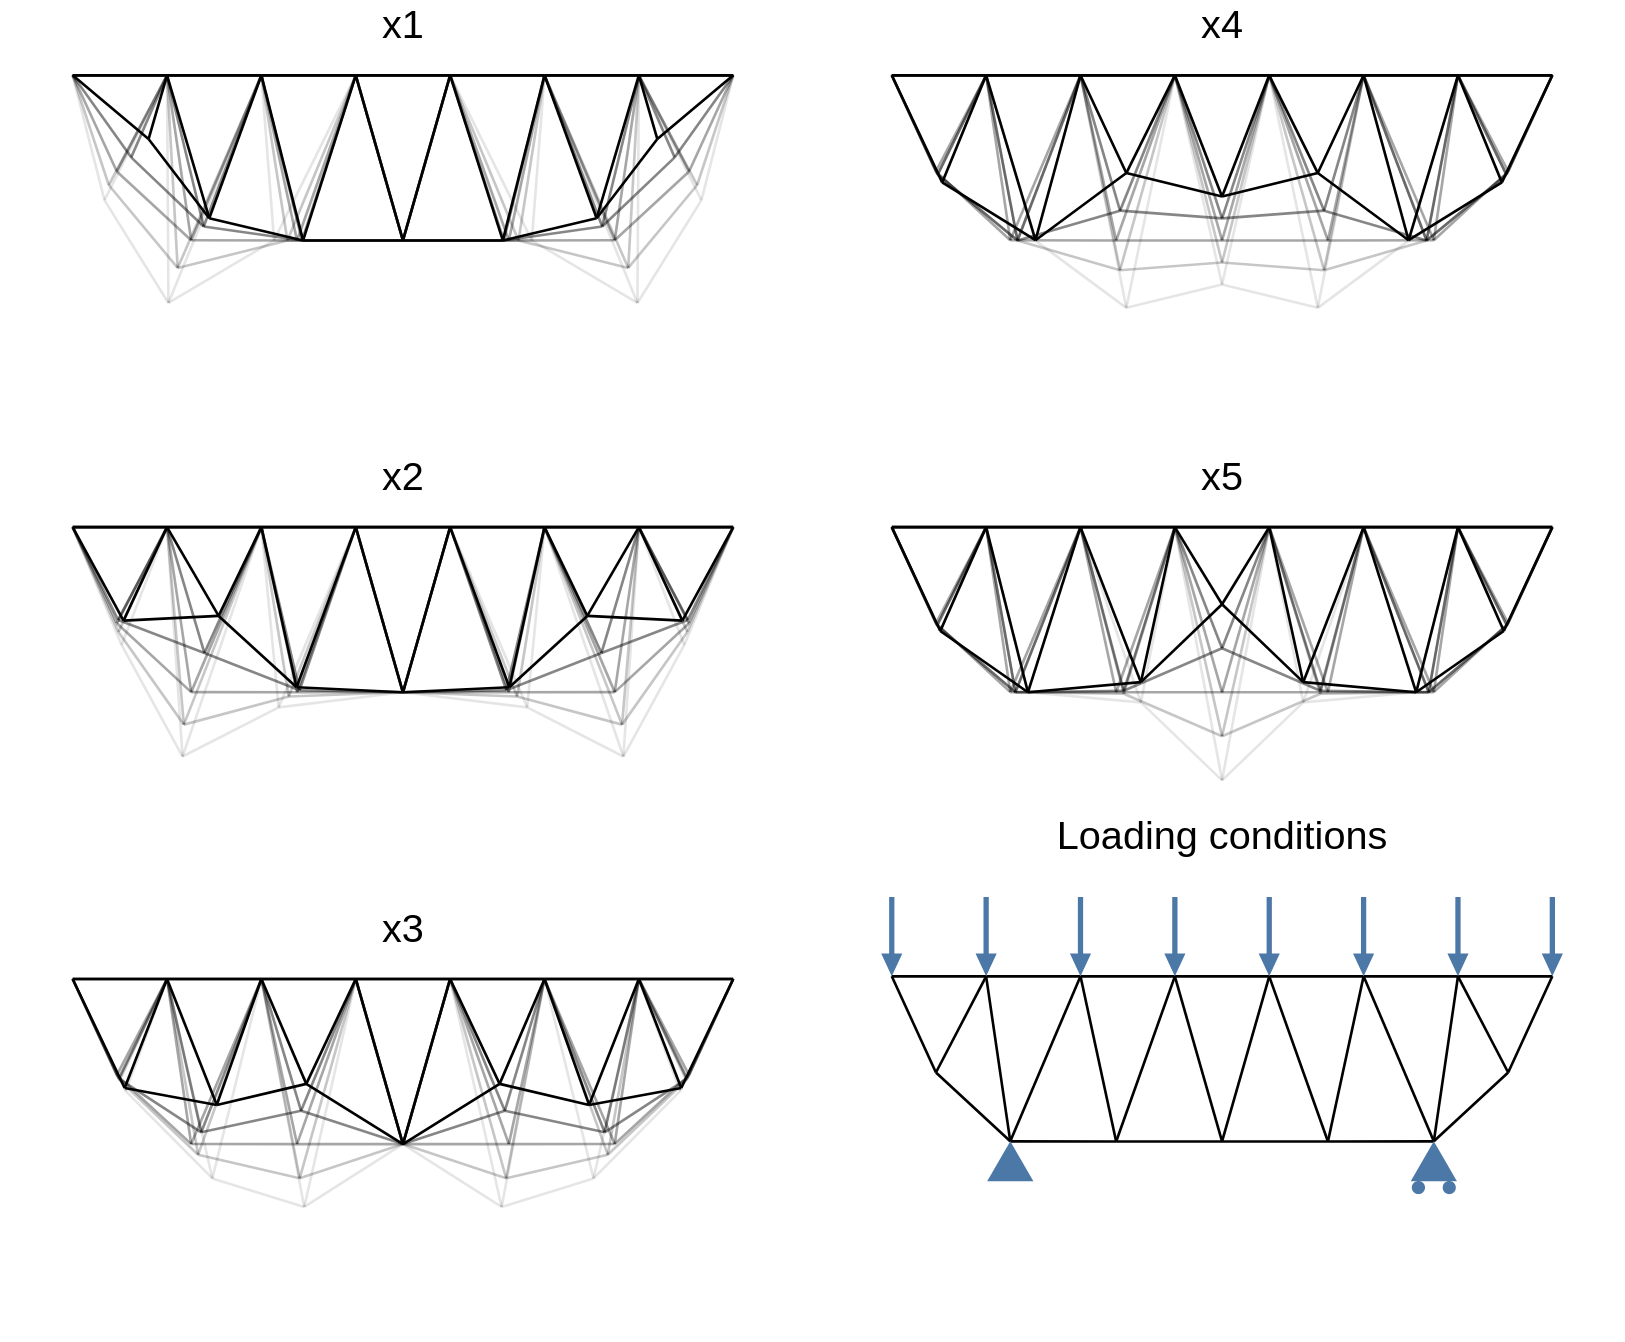

In [3]:
# alt.themes.enable('none')
sweepDirs = glob.glob('data/2D_Truss_v1.3/conmech/param_sweep*/')
width = 600
pad = 7
domX = [-5,55]
domY = [-20-pad,0]

sweepPlotList = []
for i,dataDir in enumerate(np.sort(sweepDirs)):
    print(f'loading from {dataDir}')
    allGraphs = loadConmechGraphs(dataDir)
    
    # make a title
    title = alt.Chart(
        {'values': [{"text": f'x{i+1}'}]}
    ).mark_text(size=30, align='center', font='Arial').encode(
        text="text:N"
    ).properties(width=width)
    sweepPlotList.append(title)
    
    if i==4: domY = [-20,0]

    opacities = np.linspace(0.1,0.6,5)
    opacities[-1] = 1
    plotList = [plotTruss(g, withoutConfigure=True, 
                          lineOpacity=o, 
                          baseColor='#000000',
                          domX=domX, 
                          domY=domY, 
                width=width) for g,o in zip(allGraphs, opacities)]
    sweepPlot = alt.layer(*plotList)
    sweepPlotList.append(sweepPlot)
    
# make a title
nomTitle = alt.Chart(
    {'values': [{"text": f'Loading conditions'}]}
).mark_text(size=30, align='center', font='Arial').encode(
    text="text:N"
).properties(width=width)
    
domY = [-20,0+pad]
nomDesign = plotTruss(allGraphs[2], 
                      withoutConfigure=True, 
                      domX=domX, 
                      domY=domY, 
                      width=width,
                      showLoads=True,
                      showSupports=True,
                      baseColor='#000000')
    
col0 = alt.vconcat(*sweepPlotList[:6])
col1 = alt.vconcat(*sweepPlotList[6:],nomTitle,nomDesign)
fig = alt.hconcat(col0, col1, background='white').configure_view(strokeOpacity=0)
saveAsImage(fig, 'figures/desSpace.png', widthInches=3.25, dpi=500)

# Error plot and sample predictions

In [4]:
# load model
gcn = FeaStNet()
gcn.loadModel('results/gcn01/checkpoint_94')

# load data
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
allGraphsUnfiltered = loadConmechGraphs(dataDir)
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

# run inference
predictions = gcn.predict(testData)
resultsDictWide = computeFieldLossMetrics([g.y.cpu().numpy() for g in testData], 
                              predictions, 
                              baselineRef=None, level='field')
resultsDict = [dict(zip(resultsDictWide,t)) for t in zip(*resultsDictWide.values())]
df = pd.DataFrame(resultsDict)
df['Percentile'] = df['mse'].rank(pct=True)
df = df.sort_values(['Percentile'])

image size: (1625, 1015)


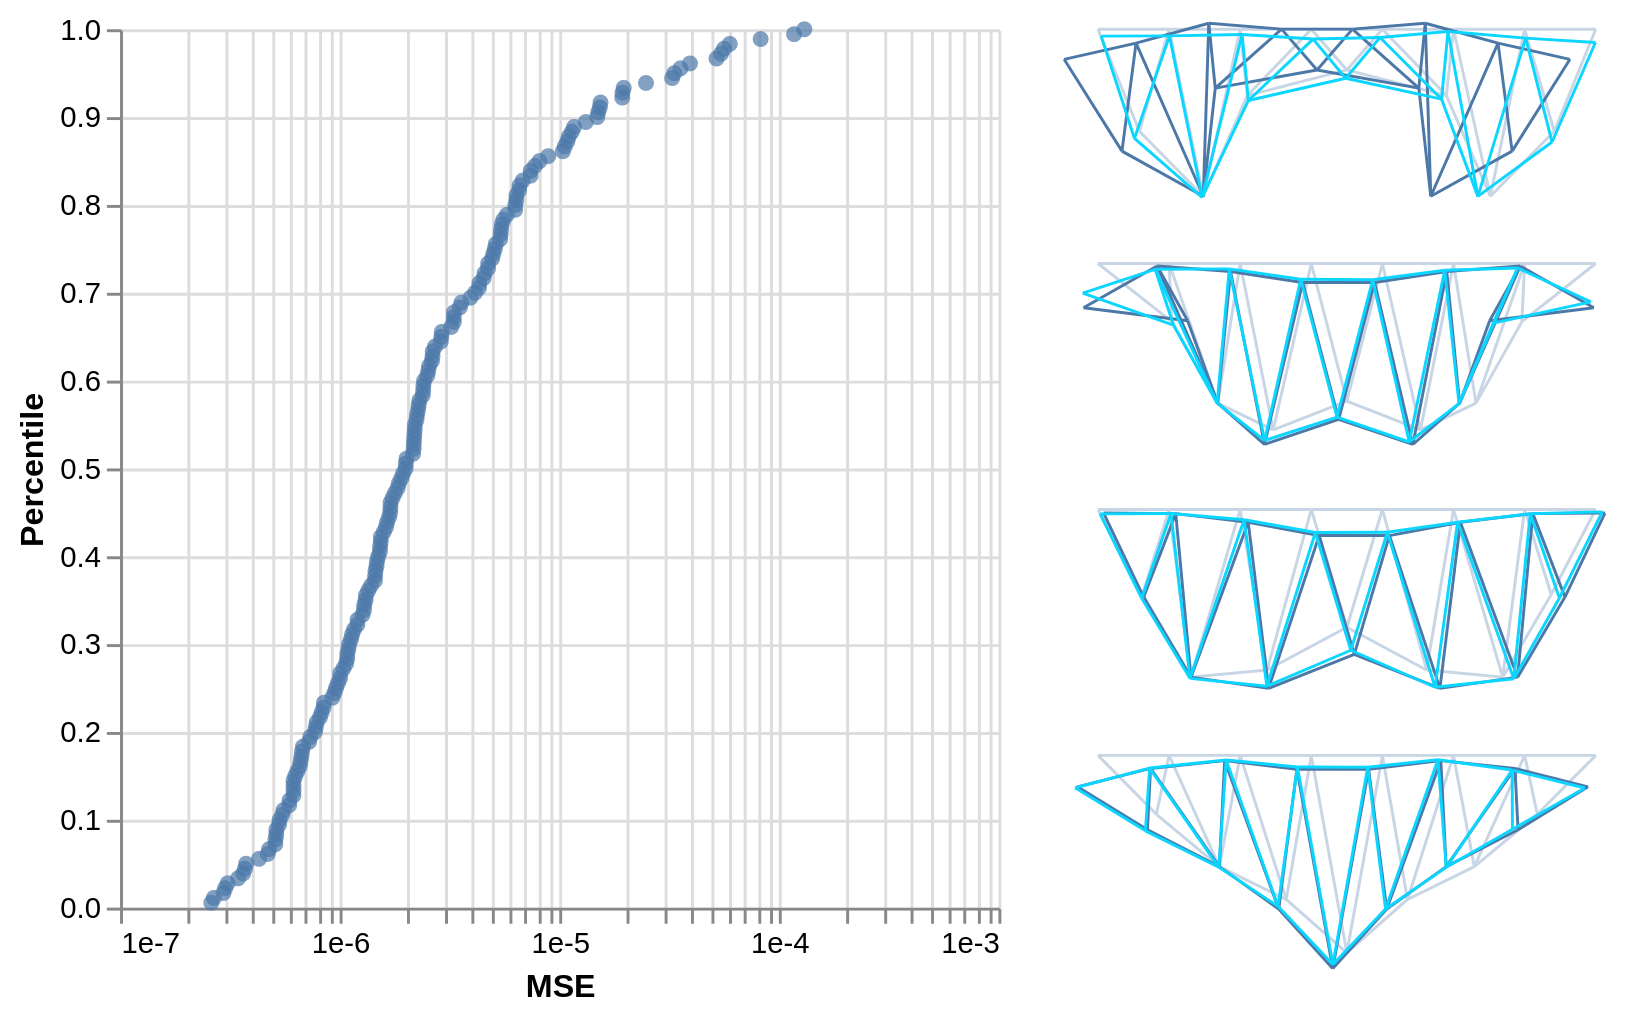

In [5]:
cdf = alt.Chart(df).mark_circle().encode(
    y=alt.Y('Percentile:Q'),
    x=alt.X('mse:Q', scale=alt.Scale(type='log'), axis=alt.Axis(tickCount=5, format=".0e"), title='MSE'),
).properties(width=300, height=300)

trussList = []
for percentileTarget in [1.0, 0.75, 0.5, 0.25]:
    i = df[df.Percentile >= percentileTarget].index[0]
    t = plotTruss(testData[i], 
                  showDeformed=True, 
                  prediction=predictions[i], 
                  defScale=200, 
                  withoutConfigure=True, 
                  width=170, 
                  lineWidth=1)
    trussList.append(t)
    
col0 = alt.vconcat(*trussList)

fig = alt.hconcat(cdf, col0).configure_view(strokeOpacity=0)
saveAsImage(fig, 'figures/errorPlots.png', widthInches=3.25, dpi=500)

# Samples from a single group

In [6]:
# load data
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
allGraphsUnfiltered = loadConmechGraphs(dataDir)
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

allPts = np.concatenate([g.pos.numpy() for g in allGraphsUnfiltered])
print(np.min(allPts, axis=0))
print(np.max(allPts, axis=0))

[  0.  -24.5]
[50.  0.]


image size: (1625, 778)


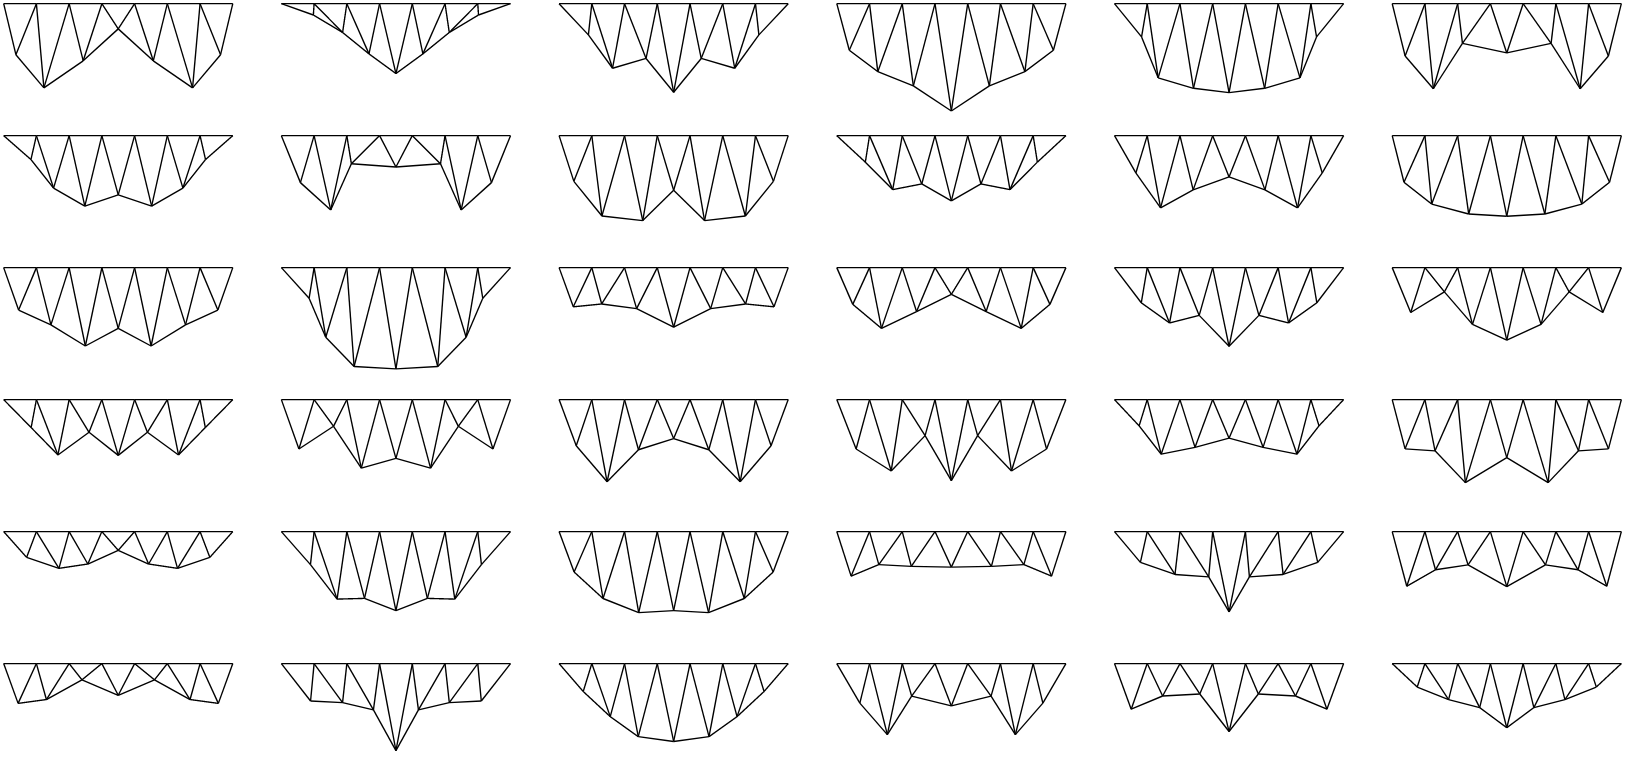

In [7]:
plotList = [plotTruss(g, 
                      width=500, 
                      domX=[0,50], 
                      domY=[-24.5,0], 
                      lineWidth=3, 
                      withoutConfigure=True, 
                      baseColor='#000000') for g in testData[:36]]
columnList = [alt.vconcat(*plotList[6*i:6*(i+1)], spacing=40) for i in range(6)]
fig = alt.hconcat(*columnList, spacing=100, background='white').configure_view(strokeOpacity=0)

saveAsImage(fig, 'figures/des7Samples01.png', widthInches=3.25, dpi=500)

# Samples from several groups

In [8]:
# load data
doeDirs = np.sort(glob.glob('data/2D_Truss_v1.3/conmech/*1000/'))
trainSets ,valSets ,testSets = {}, {}, {}
for doeDir in doeDirs:
    designName = doeDir.split('/')[-2].split('_N')[0]
    print(f'loading {designName}')
    allGraphsUnfiltered = loadConmechGraphs(doeDir)
    allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
    trainData, valData, testData = partitionGraphList(allGraphs)
    trainSets[designName] = trainData
    valSets[designName] = valData
    testSets[designName] = testData

loading design_5
loading design_6
loading design_7
loading design_8
loading design_9


image size: (1625, 1353)


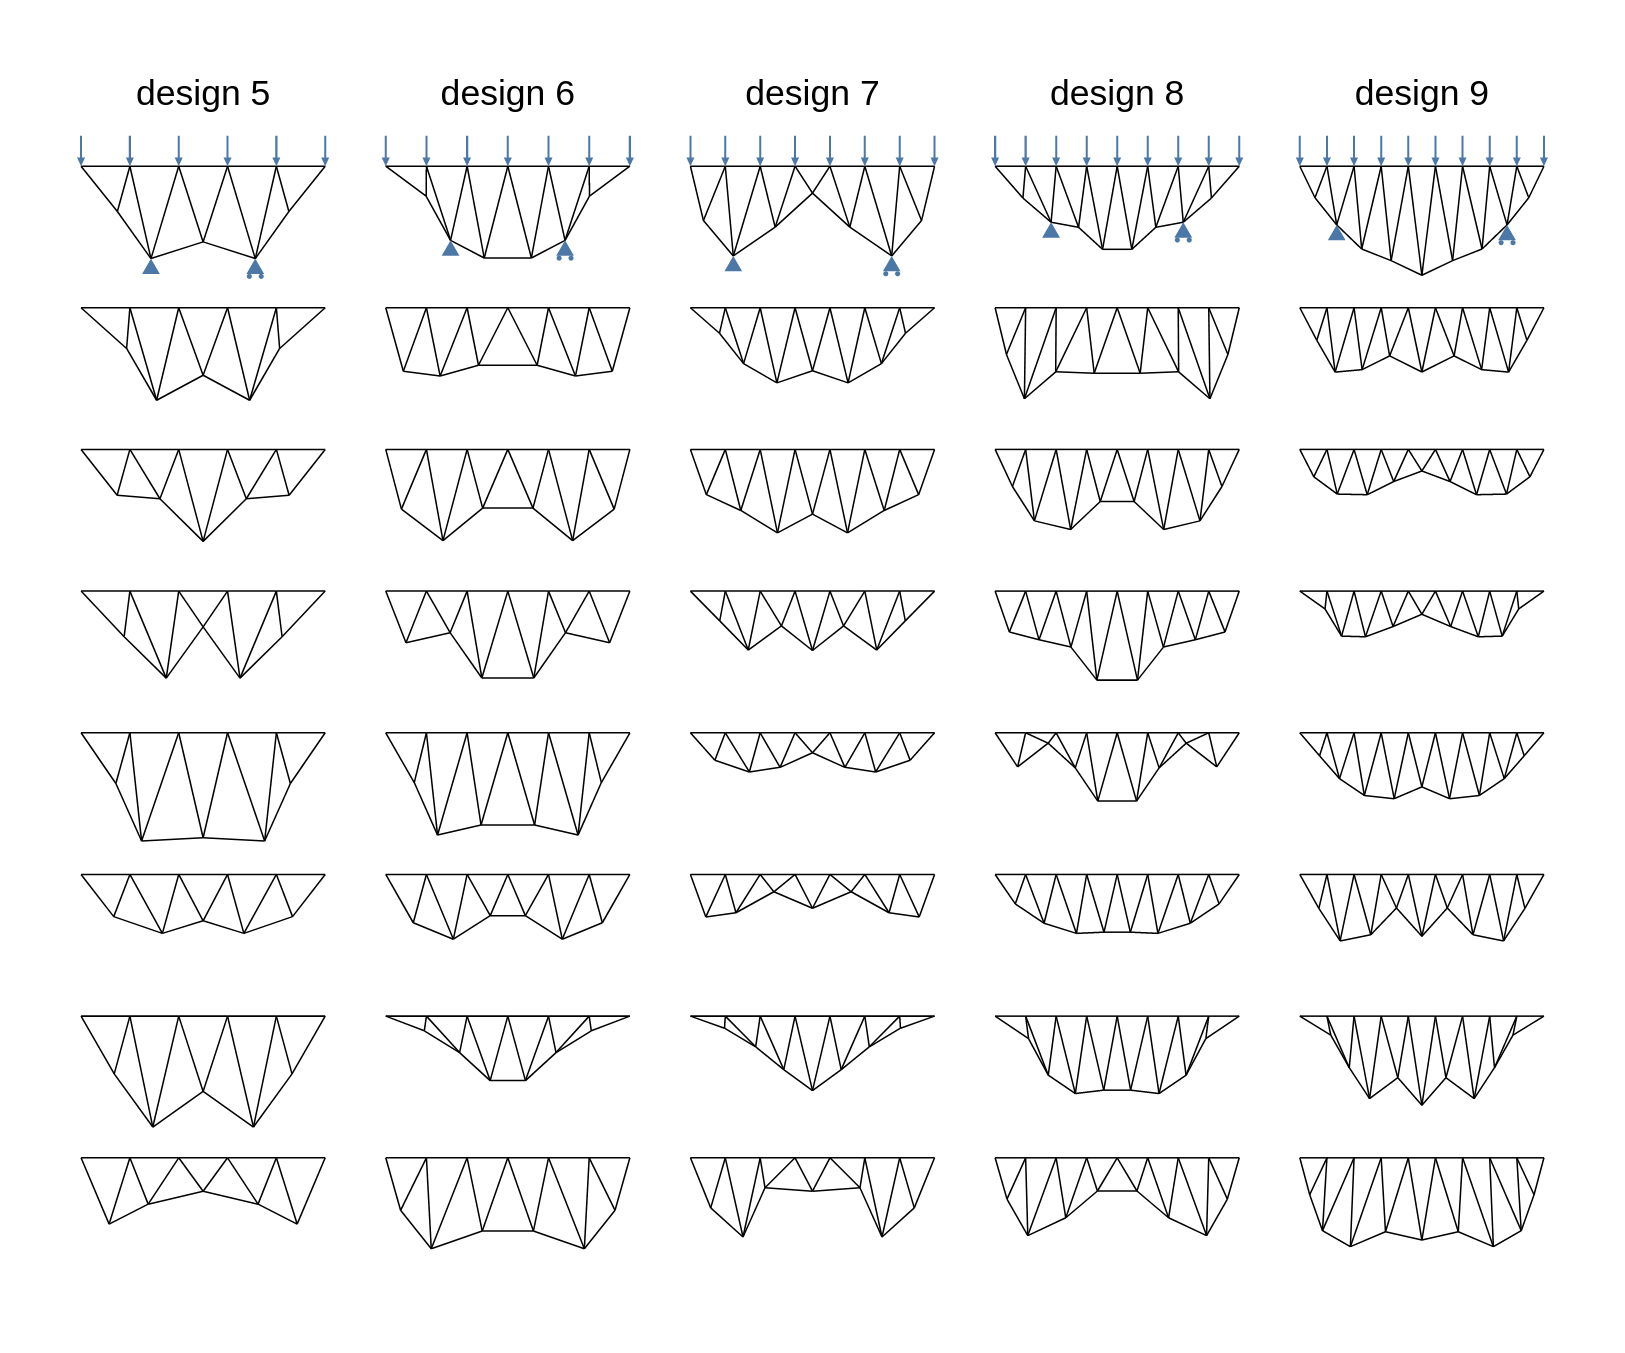

In [28]:
columnList = []
width = 500
pad = 150
for testName, testSet in testSets.items():
    # make label
    title = alt.Chart(
        {'values': [{"text": testName.replace('_', ' ')}]}
    ).mark_text(size=70, align='center', font='Arial').encode(
        text="text:N"
    ).properties(width=width)
    
    plotList = []
    for i,g in enumerate(testSet[:8]):
        domY = [-24.5,0+7] if i==0 else [-24.5,0]
        plotList.append(plotTruss(g, 
                          width=width, 
                          domX=[-1,51], 
                          domY=domY, 
                          lineWidth=3,
                          showLoads=(i==0),
                          showSupports=(i==0),
                          withoutConfigure=True, 
                          baseColor='#000000'))
    columnList.append(alt.vconcat(title,*plotList, spacing=40))
fig = alt.hconcat(*columnList, spacing=100, background='white').configure(
    padding={'top':pad, 'bottom':pad, 'left':pad, 'right':pad}
).configure_view(strokeOpacity=0)
saveAsImage(fig, 'figures/multigroupSamples.png', widthInches=3.25, dpi=500)

# Testing shapes

In [10]:
# width=600
# graph = testData[0]
# dfPoints = pd.DataFrame(graph.pos.numpy(), columns=['x', 'y'])
# pad = 5
# domX = [dfPoints['x'].min(), dfPoints['x'].max()]
# domY = [dfPoints['y'].min()-pad, dfPoints['y'].max()+pad]
# rangeX = domX[1]-domX[0]
# rangeY = domY[1]-domY[0]
# height = width*rangeY/rangeX
# domY

In [11]:
# ###############################################################################
# def plotTruss(graph, showDeformed=False, defScale=10, showUndeformed=True, prediction=None, 
#               baseColor='#4C78A8', fadedColor='#C7D5E5', brightColor='#0AD6FF', loadColor='#4C78A8', width=600, 
#               domX='auto', domY='auto', lineWidth=2.0, lineOpacity=1.0, 
#               showPoints=False, pointSize=1, withoutConfigure=False, background='white', showAxis=False,
#               showSupports=False, showLoads=False):
    
#     dfPoints = pd.DataFrame(graph.pos.numpy(), columns=['x', 'y'])
#     domX = [dfPoints['x'].min(), dfPoints['x'].max()] if domX=='auto' else domX
#     domY = [dfPoints['y'].min(), dfPoints['y'].max()] if domY=='auto' else domY
#     rangeX = domX[1]-domX[0]
#     rangeY = domY[1]-domY[0]
#     height = width*rangeY/rangeX  # should guarentee equal aspect ratio
#     chartList = []

#     if showUndeformed and not showDeformed:
#         chartList.extend(plotGraph(graph.pos.numpy(), graph.edge_index, domX, domY, color=baseColor, 
#                                    lineWidth=lineWidth, lineOpacity=lineOpacity, showPoints=showPoints, pointSize=pointSize, showAxis=showAxis))
        
#     if showDeformed and not showUndeformed:
#         chartList.extend(plotGraph((graph.pos+defScale*graph.y).numpy(), graph.edge_index, domX, domY, color=baseColor, 
#                                    lineWidth=lineWidth, lineOpacity=lineOpacity, showPoints=showPoints, pointSize=pointSize, showAxis=showAxis))
        
#     if showUndeformed and showDeformed:
#         chartList.extend(plotGraph(graph.pos.numpy(), graph.edge_index, domX, domY, color=fadedColor, 
#                                    lineWidth=lineWidth, lineOpacity=lineOpacity, showPoints=showPoints, pointSize=pointSize, showAxis=showAxis))
#         chartList.extend(plotGraph((graph.pos+defScale*graph.y).numpy(), graph.edge_index, domX, domY, color=baseColor, 
#                                    lineWidth=lineWidth, lineOpacity=lineOpacity, showPoints=showPoints, pointSize=pointSize, showAxis=showAxis))
        
#     if prediction is not None:
#         chartList.extend(plotGraph((graph.pos+defScale*prediction).numpy(), graph.edge_index, domX, domY, color=brightColor, 
#                                    lineWidth=lineWidth, lineOpacity=lineOpacity, showPoints=showPoints, pointSize=pointSize, showAxis=showAxis))
        
#     if showSupports:
#         chartList.extend(plotSupports(graph, width, height, domX, domY, color=loadColor, size=35))
        
#     if showLoads:
#         chartList.extend(plotLoads(graph, width, height, domX, domY, color=loadColor, size=20))
        
#     if withoutConfigure:
#         return alt.layer(*chartList).properties(width=width, height=height)
#     else:
#         return alt.layer(*chartList, background=background).configure_view(strokeOpacity=0).properties(width=width, height=height)


# ###############################################################################
# def plotGraph(pos, edge_index, domX, domY, color='#4C78A8', showPoints=False, lineWidth=2.0, lineOpacity=1, pointSize=1.0, showAxis=False):
#     chartList = []
#     pointOpacity = 1 if showPoints else 0
#     df = pd.DataFrame(pos, columns=['x', 'y'])
#     axis = alt.Axis() if showAxis else None
#     base = alt.Chart(df).mark_circle().encode(
#         alt.X('x:Q', scale=alt.Scale(domain=domX, nice=False), axis=axis), 
#         alt.Y('y:Q', scale=alt.Scale(domain=domY, nice=False), axis=axis),
#         opacity=alt.value(pointOpacity),
#         color = alt.value(color),
#         size = alt.value(pointSize)
#     )
#     chartList.append(base)
    
#     start, end = edge_index
#     for i,j in zip(start, end):
#         if i < j:
#             line = alt.Chart(df.iloc[[i,j]]).mark_line().encode(
#                         alt.X('x:Q'), 
#                         alt.Y('y:Q'),
#                         color=alt.value(color),
#                         opacity=alt.value(lineOpacity),
#                         size=alt.value(lineWidth)
#                     )
#             chartList.append(line)
#     return chartList

# ###############################################################################
# def plotSupports(graph, width, height, domX, domY, color='#4C78A8', size=35):
#     rangeX = domX[1]-domX[0]
#     rangeY = domY[1]-domY[0]
    
#     numPts = graph.pos.shape[0]
#     chartList = []
#     for i in range(numPts):
#         if graph.x[i,0]==1 or graph.x[i,1]==1:
#             pos = graph.pos.numpy()[i,:]
#             pixelPos = [width*(pos[0]-domX[0])/rangeX, -height*(pos[1]-domY[1])/rangeY]
#             if graph.x[i,0]==1 and graph.x[i,1]==1:
#                 chartList.append(plotPinSupport(pixelPos, size=size, color=color))
#             elif graph.x[i,1]==1:
#                 chartList.append(plotPinSupport(pixelPos, size=size, color=color))
#                 chartList.append(plotRollerSupport(pixelPos, size=size, color=color))
#             else:
#                 print('WARNING: VERTICAL ROLLER NOT IMPLEMENTED')
                
#     return chartList

# ###############################################################################
# def plotLoads(graph, width, height, domX, domY, color='#4C78A8', size=10):
#     rangeX = domX[1]-domX[0]
#     rangeY = domY[1]-domY[0]
    
#     numPts = graph.pos.shape[0]
#     chartList = []
#     for i in range(numPts):
#         if graph.x[i,2]!=0:
#             pos = graph.pos.numpy()[i,:]
#             pixelPos = [width*(pos[0]-domX[0])/rangeX, -height*(pos[1]-domY[1])/rangeY]
#             magnitude = np.abs(graph.x[i,2])
#             chartList.append(plotForce(pixelPos, size=size, color=color))
# #             chartList.append(plotForceLabel(magnitude, pos.tolist()))
#     return chartList

# ###############################################################################
# def plotPinSupport(pixelPos, size=35, color='#4C78A8'):
#     triPts = np.array([[0, 0], 
#                        [-1/2.0, np.sqrt(3.0)/2.0], 
#                        [1/2.0, np.sqrt(3.0)/2.0], 
#                        [0, 0]])
#     triPts *= size
#     triPts += pixelPos
#     triangle = geojson.Polygon([triPts.tolist()])
#     tFig = alt.Chart(triangle).mark_geoshape(color=color).encode().properties(
#         projection={'type': 'identity', 'scale': 1, 'translate':[0,0]})
#     return tFig

# ###############################################################################
# def plotRollerSupport(pixelPos, size=35, color='#4C78A8'):
#     theta = np.linspace(0,2*np.pi,num=32,endpoint=True).reshape(-1,1)
#     cirPts = np.concatenate([np.cos(theta), np.sin(theta)], axis=1)
    
#     cirPts *= size/7
#     cirPts += pixelPos
    
#     cirPts1 = cirPts + [size/3,size]
#     cirPts2 = cirPts + [-size/3,size]
    
#     cir1 = geojson.Polygon([cirPts1.tolist()])
#     cir2 = geojson.Polygon([cirPts2.tolist()])
#     featCol = geojson.FeatureCollection([cir1, cir2])
#     cirData = alt.InlineData(values=featCol, format=alt.DataFormat(property='features',type='json')) 
#     cFig = alt.Chart(cirData).mark_geoshape(color=color).encode().properties(
#         projection={'type': 'identity', 'scale': 1, 'translate':[0,0]})
#     return cFig

# ###############################################################################
# def plotForce(pixelPos, size=10, color='#4C78A8', L=3, w=0.1):
#     arPts = np.array([[0.0, 0.0], 
#                        [-4*w, -np.sqrt(3.0)/2.0], 
#                        [-w, -np.sqrt(3.0)/2.0], 
#                        [-w, -L], 
#                        [w, -L], 
#                        [w, -np.sqrt(3.0)/2.0], 
#                        [4*w, -np.sqrt(3.0)/2.0], 
#                        [0.0, 0.0]])
#     arPts *= size
#     arPts += pixelPos
#     arrow = geojson.Polygon([arPts.tolist()])
#     aFig = alt.Chart(arrow).mark_geoshape(color=color).encode().properties(
#         projection={'type': 'identity', 'scale': 1, 'translate':[0,0]})
#     aFig
#     return aFig

# ###############################################################################
# def plotForceLabel(val, pos, size=25, shift=[1,5], unitStr='Kips'):
#         return alt.Chart(
#             {'values': [{"text": f'{val}\n{unitStr}', 
#                          'x':pos[0]+shift[0], 
#                          'y':pos[1]+shift[1]}]}
#         ).mark_text(size=size, align='left', font='Arial', lineBreak='\n').encode(
#             x='x:Q',
#             y='y:Q',
#             text="text:N"
#         ).properties()


# plotTruss(testData[0], baseColor='#000000', domX=[0-5,50+5], domY=[-24.5,0+10], showSupports=True, showLoads=True)

In [12]:
print(f'{2}'+'\n'+f'{3}')

2
3
